In [667]:
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
res = res[((res.padj_58 < 0.05) | (res.padj_50 < 0.05)) & (res.Sign == 'Same')]

cols = ['external_gene_name', 'log2FoldChange_{0}', 'padj_{0}']
fetch = lambda x: [c.format(x) for c in cols]
rename = lambda x: {'log2FoldChange_{0}'.format(x): 'log2FoldChange', 'padj_{0}'.format(x): 'padj'}

a = res[fetch('58')].rename(columns=rename('58'))
b = res[fetch('50')].rename(columns=rename('50'))
a['data'] = '58'
b['data'] = '50'
new = pd.concat([a[a.padj < 0.05], b[b.padj < 0.05]])
cat_type = pd.CategoricalDtype(categories=['50', '58'], ordered=True)
new.data = new.data.astype(cat_type)
new.head()
new.groupby('data').external_gene_name.count()

data
50    1473
58     487
Name: external_gene_name, dtype: int64

In [668]:
tissues = pd.read_csv('../data/tissue_annotations.tsv', sep='\t', header=None, names=['wbid', 'external_gene_name', 'target_id', 'species', 'tissue'])
tissues = tissues[tissues.wbid.isin(res.index)]
tissues.tissue = tissues.tissue.str.replace('_', '-')

counts = tissues.groupby('tissue').wbid.count()

print('tissues originally:', tissues.tissue.nunique())
tissues = tissues[tissues.tissue.isin(counts.index[counts > 5])]
print('tissues afterwards:', tissues.tissue.nunique())

new = new.join(tissues.set_index('wbid').tissue)

tissues originally: 1059
tissues afterwards: 126


In [743]:
def test_tissue_direction(sig, col='log2FoldChange_58', tissues=tissues):
    size = sig.shape[0]
    p_pos = (sig[col] > 0).sum() / size
    p_neg = 1 - p_pos
    
    counted = tissues.groupby('tissue').wbid.count()
    acceptable = counted.index[counted > 10]
    tissues = tissues[tissues.wbid.isin(sig.index) & (tissues.tissue.isin(acceptable))]
    data = []
    for n, g in tissues.groupby('tissue'):
        found = sig.reindex(g.wbid).dropna()
        pos = (found[col] > 0).sum()

        if len(found) < 5:
            data += [[n, np.nan,  pos / g.wbid.nunique()]]
            continue

        pval = scipy.stats.binom_test(pos, g.wbid.nunique(), p_pos)
        data += [[n, pval, pos / g.wbid.nunique()]]
        
        if n == 'mu_int_R':
            print([col, n, pval, pos, g.wbid.nunique(), pos / g.wbid.nunique()])
            print(found)
    
    data = pd.DataFrame(data, columns=['tissue', 'pval', 'FracPos']).sort_values('pval', ascending=True)
    data = data.dropna()
    data['FracPosExpected'] = p_pos
    return data

In [755]:
alpha = 0.05
data = test_tissue_direction(res[res.padj_58 < 0.05])
data_50 = test_tissue_direction(res[res.padj_50 < 0.05], 'log2FoldChange_50')

data = pd.concat([data, data_50], keys=['58', '50']).reset_index().rename(columns={'level_0': 'dataset'}).drop('level_1', axis=1)#.sort_values('fdr')

data['MeanFracPos'] = data.groupby('tissue').FracPos.transform(np.mean)
data.sort_values('MeanFracPos', inplace=True)

fdr = fdrcorrection(data.pval, alpha=alpha, method='indep')
data['fdr'] = fdr[1]
data['logq'] = -data.fdr.apply(np.log10)
data['sig'] = fdr[0]

data.sort_values('fdr', inplace=True)

keep = data.groupby('tissue').sig.sum()
data = data[data.tissue.isin(keep[keep > 0].index)]

data.head(10)

,dataset,tissue,pval,FracPos,FracPosExpected,MeanFracPos,fdr,logq,sig
0,58,intestine,0.000002,0.617021,0.371663,0.657036,0.000166,3.779435,True
41,50,body wall musculature,0.000004,0.755760,0.605567,0.621783,0.000189,3.723290,True
42,50,hypodermis,0.000042,0.740566,0.605567,0.676735,0.001374,2.862132,True
43,50,gonad,0.000122,0.838710,0.605567,0.776498,0.002977,2.526247,True
1,58,hypodermis,0.000175,0.612903,0.371663,0.676735,0.003432,2.464496,True
44,50,sperm,0.000236,0.133333,0.605567,0.087500,0.003859,2.413515,True
45,50,intestine,0.000303,0.697051,0.605567,0.657036,0.004248,2.371808,True
2,58,sperm,0.000403,0.041667,0.371663,0.087500,0.004932,2.306946,True
46,50,anal depressor muscle,0.000504,0.788235,0.605567,0.608403,0.005488,2.260604,True
47,50,reproductive system,0.000677,0.764151,0.605567,0.724181,0.006639,2.177902,True


(-1.0, 0.5)

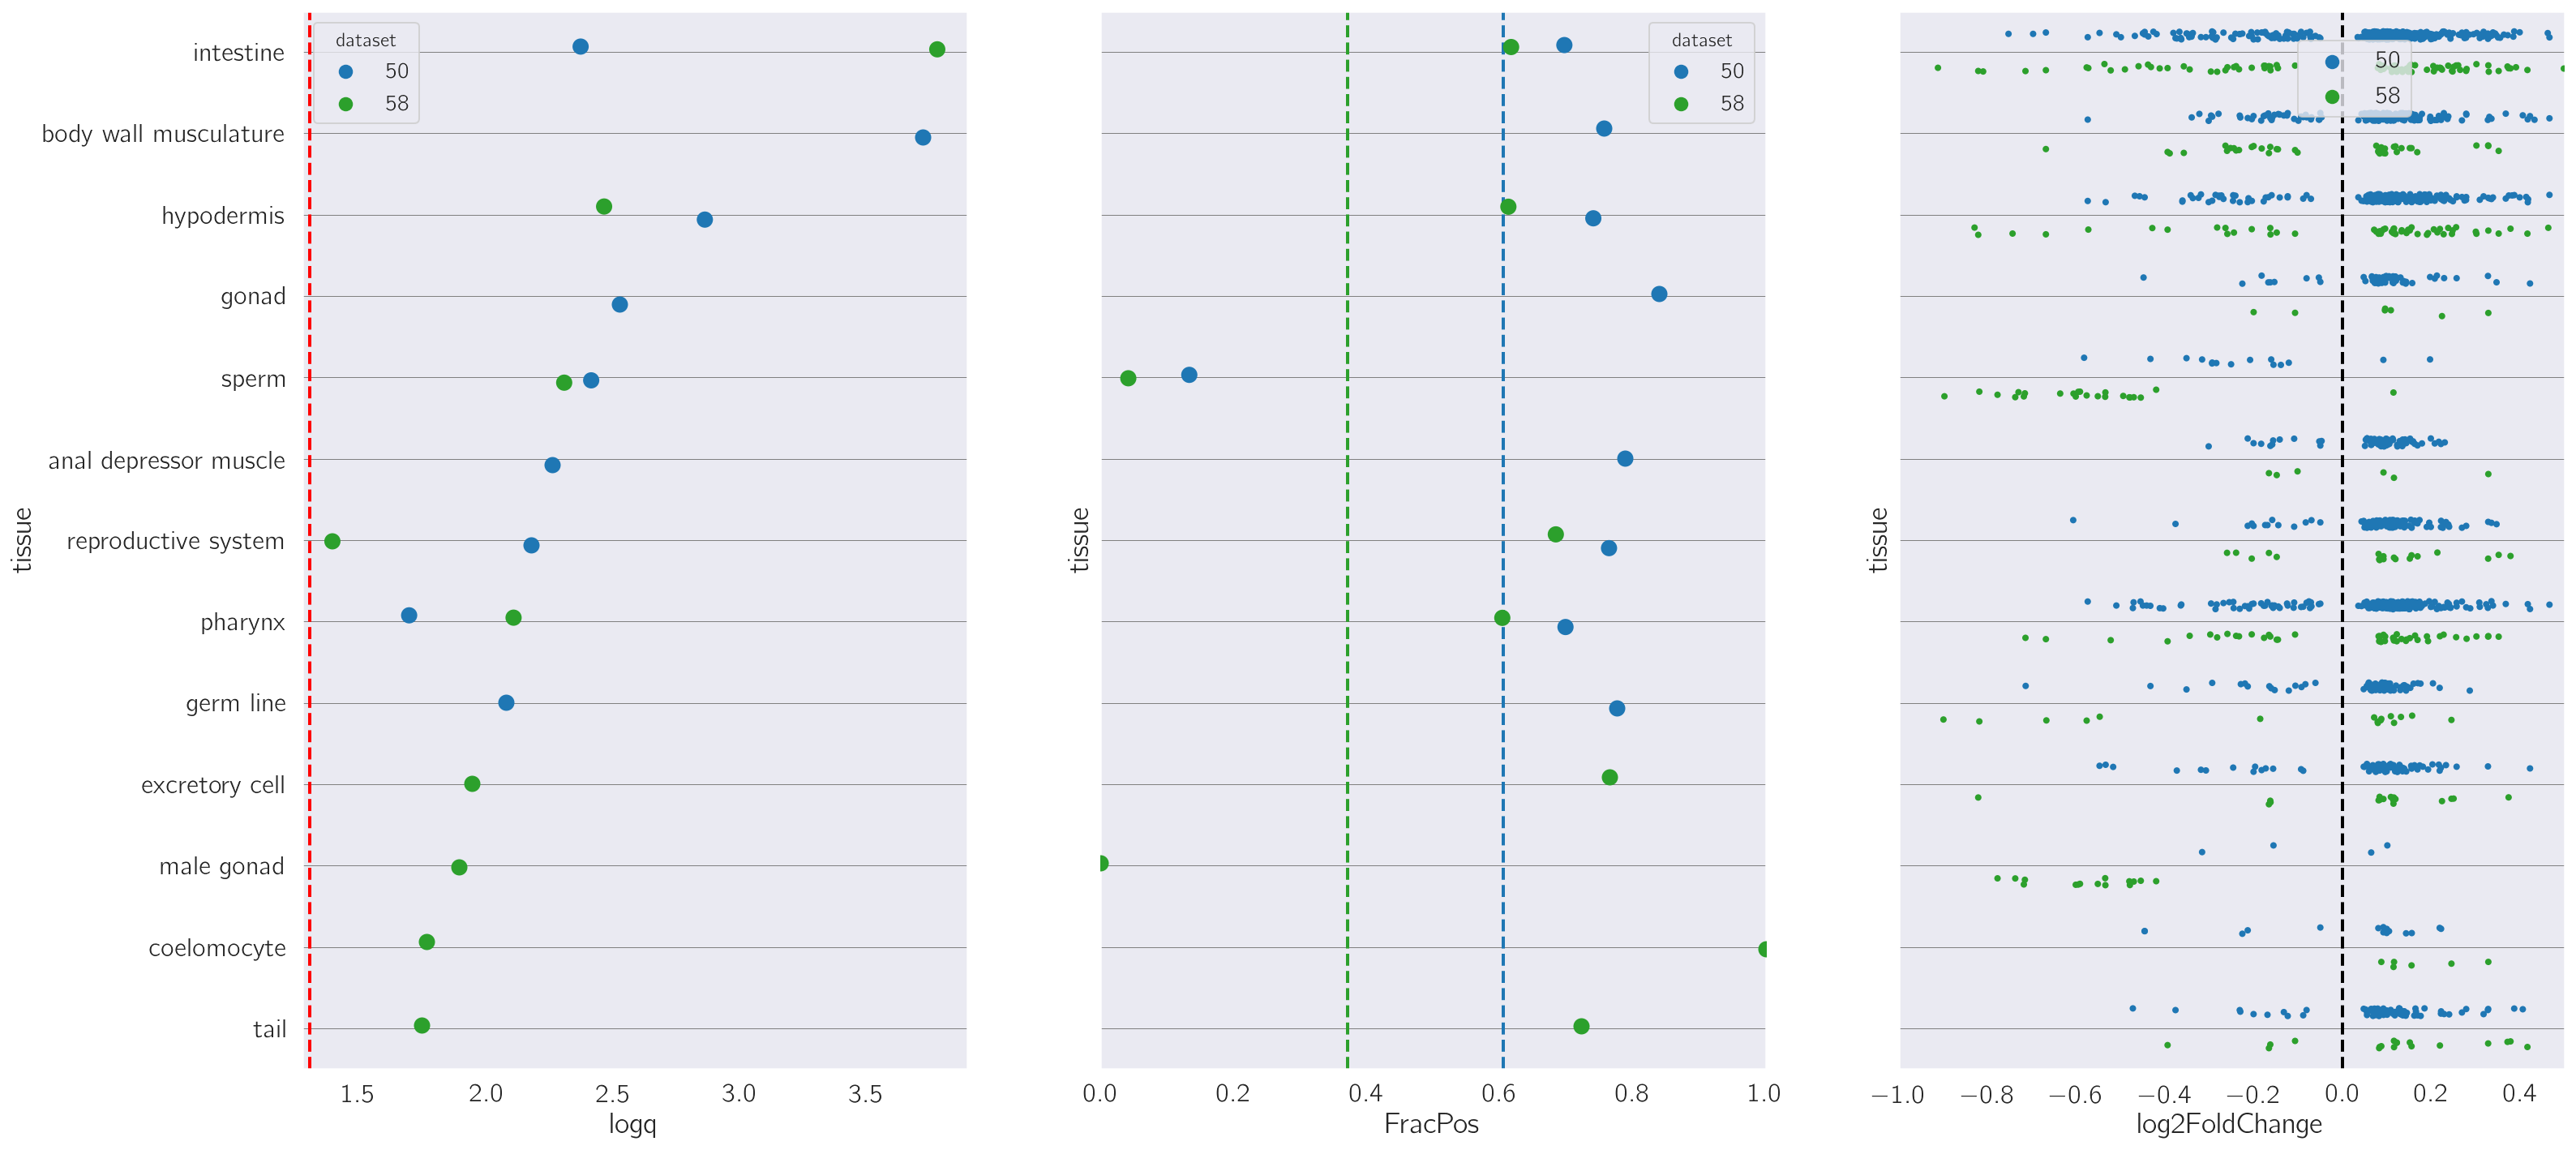

In [761]:
data.logq = data.logq.replace(np.inf, 350)

data.head()

fig, ax = plt.subplots(figsize=(25, 12), ncols=3, sharey = True)
sns.stripplot(x='logq', y='tissue', data=data[~data.tissue.str.contains('Cell') & (data.sig == True)],
              size=10, hue='dataset', hue_order=['50', '58'],
              palette=['tab:blue', 'tab:green'], ax=ax[0])
sns.stripplot(x='FracPos', y='tissue', data=data[~data.tissue.str.contains('Cell') & (data.sig == True)],
              size=10, hue='dataset', hue_order=['50', '58'],
              palette=['tab:blue', 'tab:green'], ax=ax[1])

tissue_order = pd.CategoricalDtype(categories=data.tissue.unique(), ordered=True)
tmp = new[new.tissue.isin(data.tissue)].copy()
tmp.tissue = tmp.tissue.astype(tissue_order)
tmp.sort_values('tissue', inplace=True)
sns.stripplot(x='log2FoldChange', y='tissue', size=4, hue='data', data=tmp,
              hue_order=['50', '58'], alpha=1,
              palette=['tab:blue', 'tab:green'], ax=ax[2], dodge=True)

for ai in ax:
    ai.yaxis.grid(color='gray', linewidth=.5)

# plt.xlim(-0.5, 25)
ax[0].axvline(-np.log10(alpha), ls='--', color='red', label='alpha threshold')
ax[1].axvline(data[data.dataset == '58'].FracPosExpected.unique()[0], ls='--', label='Expected Positive Fraction at 58hrs', color='tab:green')
ax[1].axvline(data[data.dataset == '50'].FracPosExpected.unique()[0], ls='--', label='Expected Positive Fraction at 50hrs', color='tab:blue')
ax[2].axvline(0, ls='--', color='black')

plt.legend(loc=(.6, .9), fontsize=15)

ax[1].set_xlim(0, 1)
ax[2].set_xlim(-1, 0.5)


In [762]:
jaccard = []
remove = ['Cell']  # so broad. why ever have it
for i, t in enumerate(data.tissue.unique()):
    for t2 in data.tissue.unique()[i + 1:]:
        if t == t2:
            continue
        current = tissues.tissue.isin([t, t2])
        counted = tissues[current].groupby('wbid').tissue.count() 
        both = (counted == 2).sum()
        min_size = tissues[current].groupby('tissue').wbid.count().min()
        min_tissue = tissues[current].groupby('tissue').wbid.count().idxmin()

        if both / min_size > 0.75:
            remove += [min_tissue]

In [763]:
print('The following list of tissues will be removed from the plot', list(set(remove)))

The following list of tissues will be removed from the plot ['Cell', 'pharynx', 'reproductive system', 'anal depressor muscle', 'tail', 'male gonad', 'excretory cell']


(-1.0, 0.5)

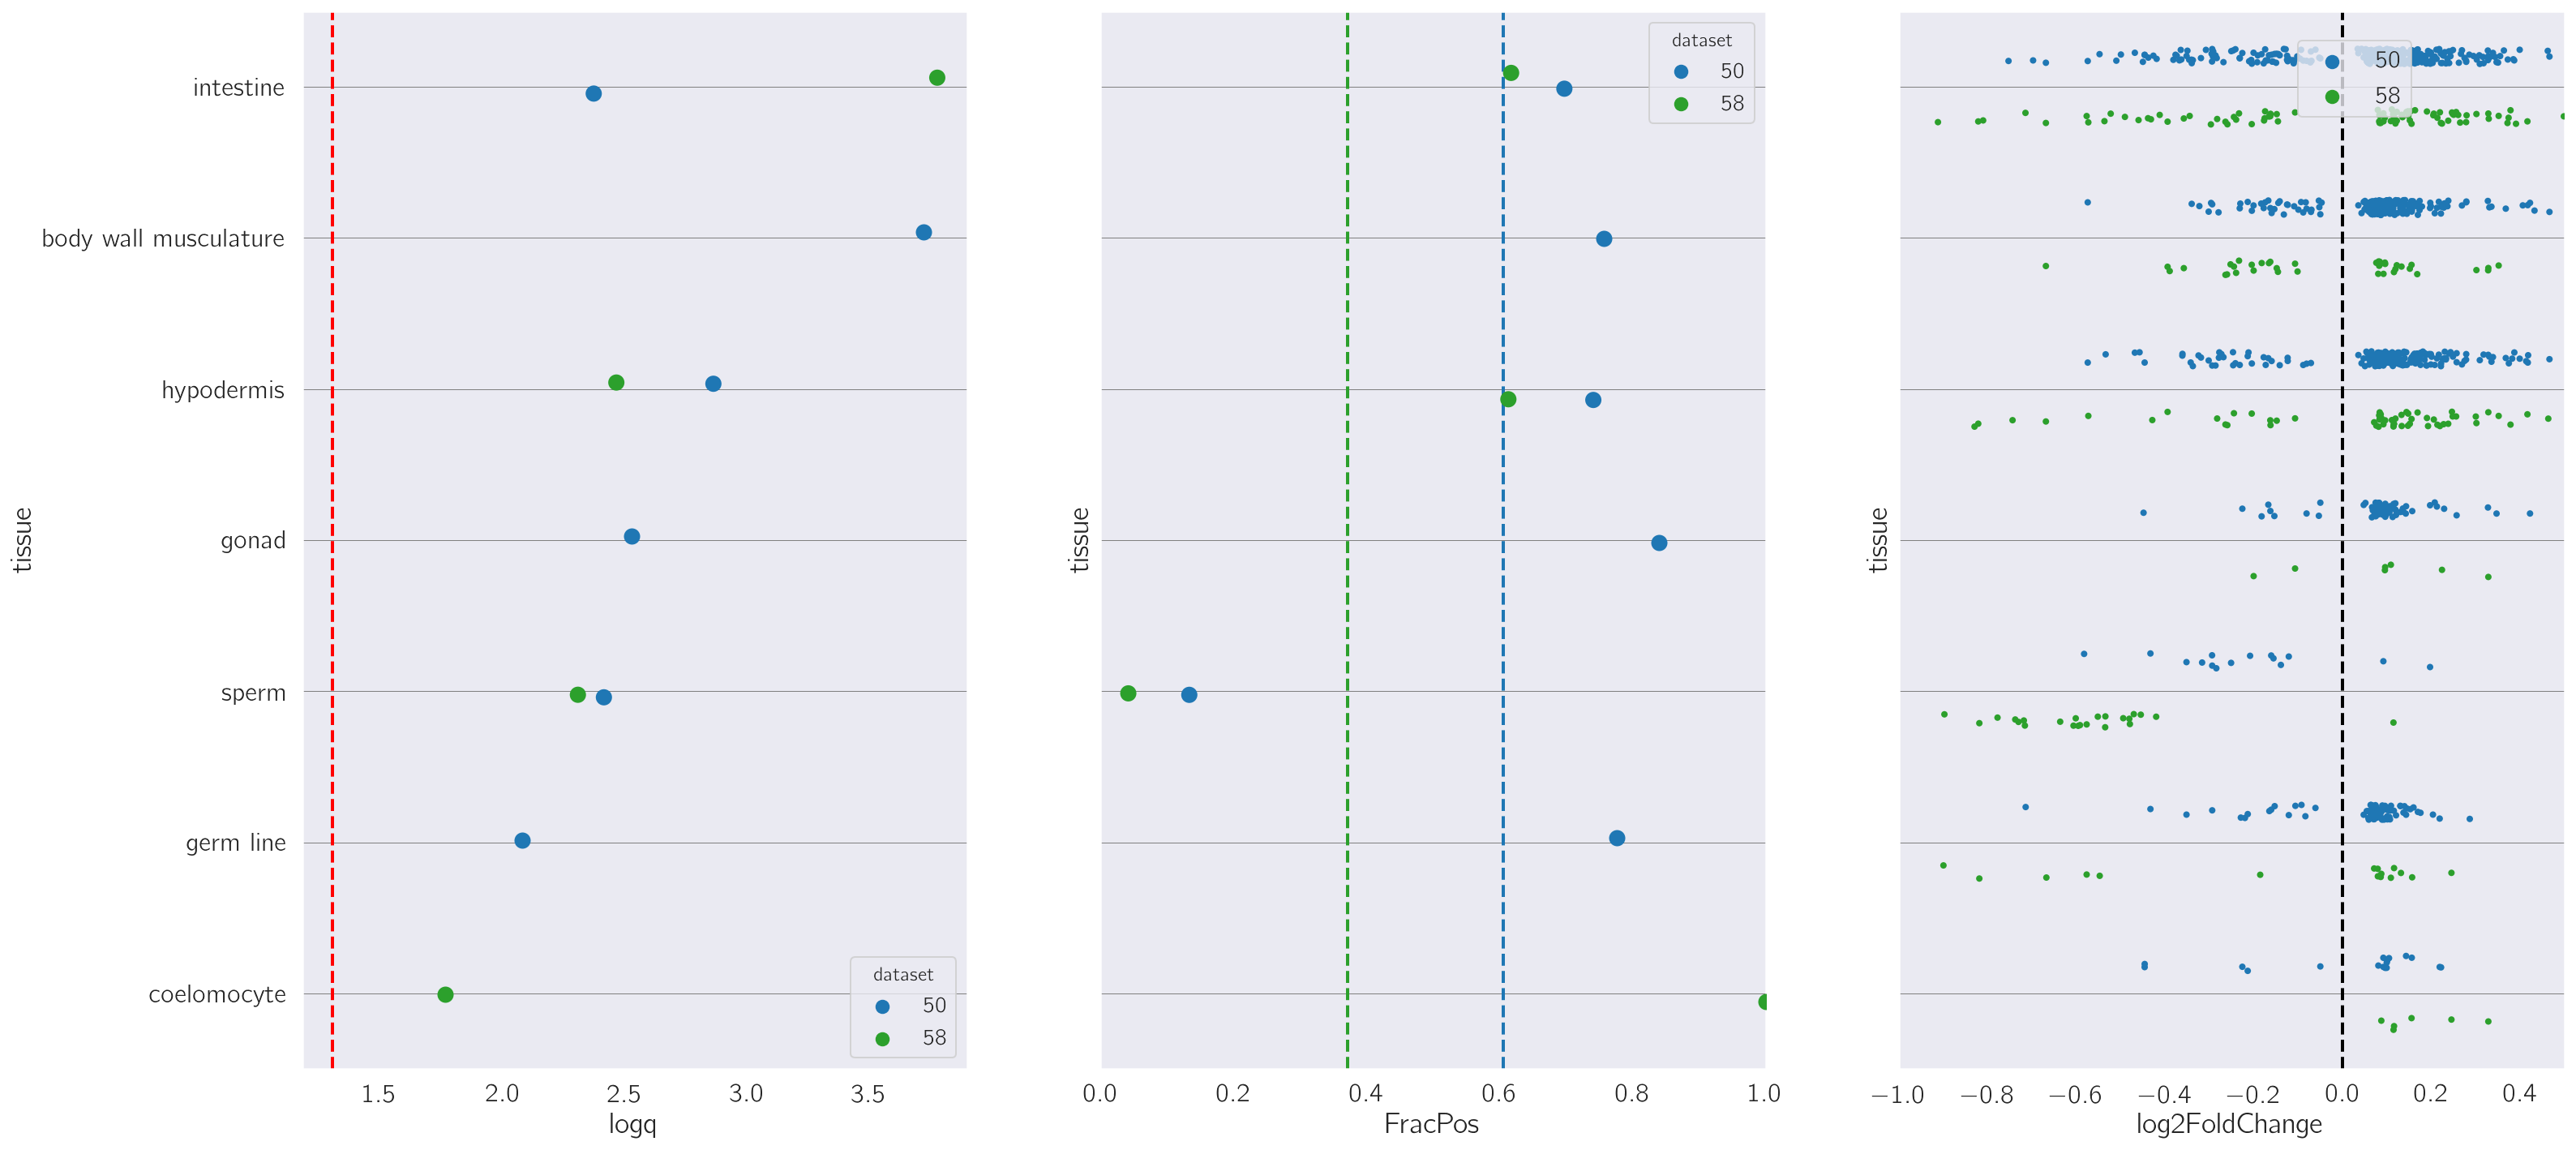

In [764]:
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)]
fig, ax = plt.subplots(figsize=(25, 12), ncols=3, sharey = True)
sns.stripplot(x='logq', y='tissue', data=to_plot,
              size=10, hue='dataset', hue_order=['50', '58'],
              palette=['tab:blue', 'tab:green'], ax=ax[0])
sns.stripplot(x='FracPos', y='tissue', data=to_plot,
              size=10, hue='dataset', hue_order=['50', '58'],
              palette=['tab:blue', 'tab:green'], ax=ax[1])

tissue_order = pd.CategoricalDtype(categories=to_plot.tissue.unique(), ordered=True)
tmp = new[new.tissue.isin(to_plot.tissue)].copy()
tmp.tissue = tmp.tissue.astype(tissue_order)
tmp.sort_values('tissue', inplace=True)
sns.stripplot(x='log2FoldChange', y='tissue', size=4, hue='data', data=tmp,
              hue_order=['50', '58'], alpha=1,
              palette=['tab:blue', 'tab:green'], ax=ax[2], dodge=True)

for ai in ax:
    ai.yaxis.grid(color='gray', linewidth=.5)

# plt.xlim(-0.5, 25)
ax[0].axvline(-np.log10(alpha), ls='--', color='red', label='alpha threshold')
ax[1].axvline(data[data.dataset == '58'].FracPosExpected.unique()[0], ls='--', label='Expected Positive Fraction at 58hrs', color='tab:green')
ax[1].axvline(data[data.dataset == '50'].FracPosExpected.unique()[0], ls='--', label='Expected Positive Fraction at 50hrs', color='tab:blue')
ax[2].axvline(0, ls='--', color='black')

plt.legend(loc=(.6, .9), fontsize=15)

ax[1].set_xlim(0, 1)
ax[2].set_xlim(-1, 0.5)